In [25]:
import os
import time
import timeit

import cv2
import imutils
import numpy as np
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# get cv2 object return cv2 object with no margin
def get_tv_frame(raw_cv2_frame):
    im_pil = Image.fromarray(raw_cv2_frame)
    bg = Image.new(im_pil.mode, im_pil.size, im_pil.getpixel((0, 0)))
    diff = ImageChops.difference(im_pil, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    dim1 = bbox[2] - bbox[0]
    dim2 = bbox[3] - bbox[1]
    # crop PILK object to bbox
    res = im_pil.crop(bbox)
    # use numpy to convert the pil_image into a numpy array
    numpy_image=np.array(res)

    # convert to a openCV2 image, notice the COLOR_RGB2BGR which means that
    # the color is converted from RGB to BGR format
    opencv_image=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    return opencv_image

In [27]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [30]:
content_image = cv2.imread("samples/content/photo_2022-02-04_11-09-57.jpg",0)
ad_image = cv2.imread("samples/break/photo_2022-02-04_11-09-58.jpg",0)
test_image = cv2.imread("samples/test_set/test1.jpg",0)
current_frame=test_image
img_dims=current_frame.shape
print(img_dims)

(576, 1280)


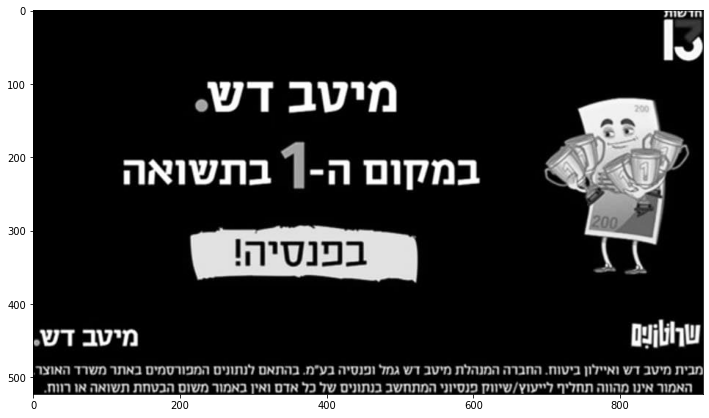

In [31]:
# from camera get TV fame
gray_tv_bbox = get_tv_frame(current_frame)
display(gray_tv_bbox)

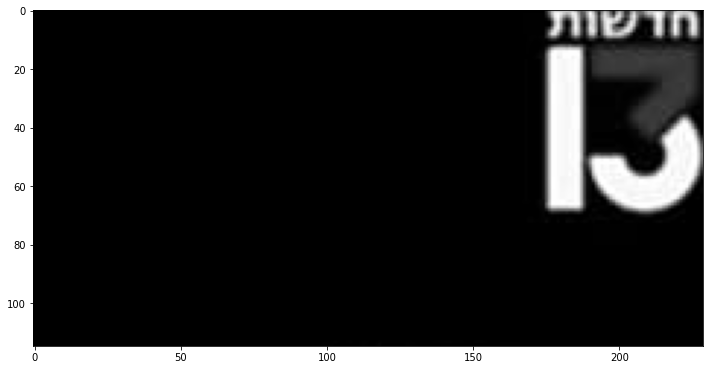

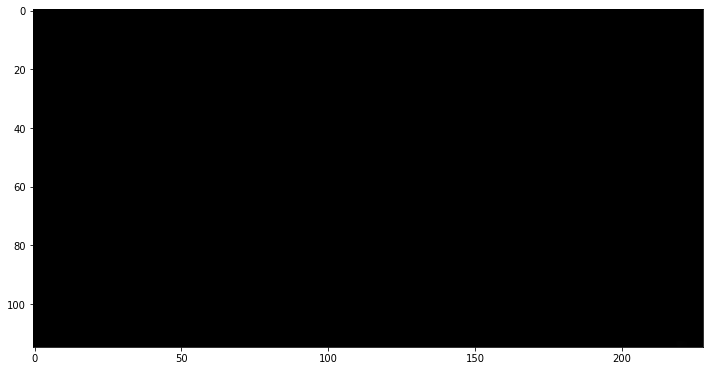

In [32]:
# get the top line only
top_strip = gray_tv_bbox[0:int((img_dims[0]*0.2)), 0:img_dims[1]]
top_strip_right_qtr=top_strip[0:top_strip.shape[0],int(top_strip.shape[1]*0.75):top_strip.shape[1]]
top_strip_left_qtr=top_strip[0:top_strip.shape[0],0:int(top_strip.shape[1]*0.25)]
display(top_strip_right_qtr)
display(top_strip_left_qtr)

In [33]:
def count_feature_matching_flann(gray_img, icon_img_path):
    icon_img = cv2.imread(icon_img_path,0)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(gray_img,None)
    kp2, des2 = sift.detectAndCompute(icon_img,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test
    for i,(match1,match2) in enumerate(matches):
        if match1.distance < 0.7*match2.distance:
            matchesMask[i]=[1,0]

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    flann_matches = cv2.drawMatchesKnn(gray_img,kp1,icon_img,kp2,matches,None,**draw_params)
    display(flann_matches)
    return flann_matches

In [34]:
def count_feature_matching_orb(gray_img, icon_img_path):
    icon_img = cv2.imread(icon_img_path,0)

    # Initiate ORB detector
    orb = cv2.ORB_create()
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(icon_img,None)
    kp2, des2 = orb.detectAndCompute(gray_img,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # Draw first 25 matches.
    show_matches = cv2.drawMatches(icon_img,kp1,gray_img,kp2,matches[:25],None,flags=2)
    display(show_matches)
    return matches



# compare dir elements to the given image, returns the number of matches of the best image.
def feature_matching_in_dir(gray_img, dir):
    listOfFiles = os.listdir(dir)
    list_of_results=[]
    list_of_results_flann=[]
    for icon_img_path in listOfFiles:
        list_of_results.append(count_feature_matching_orb(gray_img, icon_img_path))
        list_of_results_flann.append(count_feature_matching_flann(gray_img, icon_img_path))

    print("ORB list max: {}  Flann list max: {}\n".format(np.max(list_of_results),np.max(list_of_results_flann)))
    print("ORB list: {}  Flann list: {}\n".format(list_of_results,list_of_results_flann))
    return np.max(list_of_results)


In [35]:
# compares the corner from the TV to the known examples to check if it's ad-time or not
# by feature matching
def check_if_ad_time_by_corner(sub_strip_grey, corner):
    matches_ads_right=0
    matches_content_right=0
    matches_content_left=0

    if corner=='right':
        ad_path= r'channels_icon/break/right'
        content_path= r'channels_icon/break/right'

        matches_ads_right=feature_matching_in_dir(sub_strip_grey, ad_path)
        matches_content_right=feature_matching_in_dir(sub_strip_grey, content_path)

    elif corner=='left':
        #ad_path= r'channels_icon/break/left' # no indicator on left when no ads
        content_path= r'channels_icon/break/left'
        matches_content_left=feature_matching_in_dir(sub_strip_grey, content_path)

    ad_avg= matches_ads_right
    content_avg= (matches_content_right+matches_content_left)/2

    if ad_avg>content_avg:
        # means it's likely to be ad-time
        print("That's an ad\n")

    else:
        print("No ad\n")

In [36]:
check_if_ad_time_by_corner(top_strip_right_qtr, 'right')
check_if_ad_time_by_corner(top_strip_left_qtr, 'left')

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
